In [1]:
import numpy as np
from numba import njit
import pickle
from sklearn.ensemble import BaggingClassifier
from sklearn.tree._classes import DecisionTreeClassifier
from joblib import Parallel, delayed
from scipy.stats import entropy, multivariate_normal

from hyppo.tools import multimodal_independence, indep_sim, rot_ksamp
from hyppo.tools import SIMULATIONS
from hyppo.ksample._utils import k_sample_transform
from tqdm import tqdm
from hyppo.tools import * 

import sys
import os
import multiprocessing as mp
from proglearn import UncertaintyForest
from joblib import Parallel, delayed
sys.path.append('C:\\Users\\siptest\\AppData\\Roaming\\Python\\Python36\\Scripts')
%load_ext autoreload
%autoreload 2

In [2]:
class TestStat:
    def __init__(self, uf, oob_func, n_jobs=1):
        self.uf = uf
        self.oob_func = oob_func
        self.n_jobs = n_jobs
        
    def __call__(self, X, y):
        if not hasattr(self, "leaf_indices_"):
            self.leaf_indices_ = []
            for tree, voter_indices in zip(self.uf.transformers_, self.uf.voter_indices_):
                self.leaf_indices_.append(tree.apply(X[voter_indices]))

        _, counts = np.unique(y, return_counts=True)
        H_Y = entropy(counts, base=np.exp(1))
        H_YX = self._refit_apply_oob(X, y)
        return H_Y - H_YX

    def _refit_apply_oob(self, X, y):
        posteriors = np.zeros((X.shape[0], self.uf.n_classes_), dtype=np.float64)
        # posteriors = np.zeros((X.shape[0], self.uf.n_estimators, self.uf.n_classes_), dtype=np.float64)

        for tree, leaf_indices, voter_indices in zip(self.uf.transformers_, self.leaf_indices_, self.uf.voter_indices_):
        # for tree_idx, (leaf_indices, voter_indices) in enumerate(zip(self.leaf_indices_, self.uf.voter_indices_)):
            tree.tree_.value[:, :, :] = 0

            for leaf_id, yval in zip(leaf_indices, y[voter_indices]):
                tree.tree_.value[leaf_id][0, yval] += 1
                # posteriors[leaf_id,]

            proba = tree.tree_.value[leaf_indices][:, 0, :]
            normalizer = proba.sum(axis=1)[:, np.newaxis]
            normalizer[normalizer == 0.0] = 1.0 # solves divide by 0 error
            proba /= normalizer
            posteriors[voter_indices] += proba

        # Normalize to unit length, due to prior weighting
        zero_mask = posteriors.sum(1) == 0
        posteriors[~zero_mask] /= posteriors[~zero_mask].sum(1, keepdims=True)
        posteriors[zero_mask] = self.uf.empirical_prior_

        return np.mean(self.oob_func(posteriors))


In [3]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 19
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 100

In [4]:
def _perm_stat(calc_stat, x, y):
    permy = np.random.permutation(y)
    perm_stat = calc_stat(x, permy)

    return perm_stat


def perm_test(calc_stat, X, y, reps=1000, workers=1):
    """
    Calculate the p-value via permutation
    """
    # calculate observed test statistic
    stat = calc_stat(X, y)
    
    null_dist = np.asarray([_perm_stat(calc_stat, X, y) for rep in range(reps)])
    pvalue = ((null_dist >= stat).sum() + 1) / (reps + 1)


    return stat, pvalue

In [5]:
def estimate_power(sim, test):
    
    est_power = []
    for i in tqdm(SAMP_SIZES):
        print("sample size" + str(i))
        print(sim)
    
        pvalues = []
        for _ in tqdm(range(POWER_REPS)): 
            x, y = rot_ksamp(sim, n=i, p=3, noise=True)
            X, y = k_sample_transform([x, y])
            y = y.astype(int)
            y = y.ravel()
            print(X.shape)
            print(y.shape)
            uf = UncertaintyForest(
                n_estimators=100,
                tree_construction_proportion=0.5,
                kappa=np.inf,
                honest_prior="ignore",
                max_features=1.0,
                n_jobs=-2,
            )
            uf = uf.fit(X, y)
            print('Fitted')

            ce = lambda x: entropy(x, axis=1, base=np.exp(1))
            obs_stat = TestStat(uf, ce)

            reps = 100
            stat, pvalue = perm_test(obs_stat, X, y, reps=reps, workers=-2)
            print(pvalue)
            pvalues.append(pvalue)
            with open("./type_vs_attributes_test.csv", "w") as f:
                f.write(f"Test Statistic,p-value\n{stat},{pvalue}")
        num = 0
        for pval in pvalues: 
            if pval <= 0.05: 
                num += 1
        empirical_power = (1+num) / (1+POWER_REPS)
        est_power.append(empirical_power)
        
    print(est_power)
        
    
    print(sim + " done")
    np.savetxt('C:/Users/siptest/Desktop/NDD/{}_{}FixedMax_HonestSampling_100_estimators_100_reps.csv'.format(sim, "UF"),
            est_power, delimiter=',')
    
    return est_power

In [ ]:
for sim_name in tqdm(SIMULATIONS.keys()): 
    power = estimate_power(sim_name, "UF")

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:], n_colors=9)

from hyppo.tools import INDEP_TESTS

SIM_TITLES = [
    "Linear",
    "Exponential",
    "Cubic",
    "Joint Normal",
    "Step",
    "Quadratic",
    "W-Shaped",
    "Spiral",
    "Bernoulli",
    "Logarithmic",
    "Fourth Root",
    "Sine 4\u03C0",
    "Sine 16\u03C0",
    "Square",
    "Two Parabolas",
    "Circle",
    "Ellipse",
    "Diamond",
    "Noise",
    "Independence",
]

def plot_power_all():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25, 20))
    plt.suptitle(
        "Multivariate Independence Testing (Increasing Sample Size)",
        y=0.93,
        va="baseline",
    )

    print(INDEP_TESTS.keys())
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5 * i + j
            sim = list(SIMULATIONS.keys())[count]

            SAMP_SIZES = range(5, 105, 5)
            for test in INDEP_TESTS.keys():
                if test == 'kmerf' or test == 'maxmargin':
                    continue
                
                est_power = np.genfromtxt(
                    "C:/Users/siptest/hyppo/benchmarks/vs_samplesize/{}_{}.csv".format(sim, test),
                    delimiter=",")

                col.plot(SAMP_SIZES, est_power, label=INDEP_TESTS[test].__name__, lw=2)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
                col.set_ylim(-0.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(SIM_TITLES[count])
                
            SAMP_SIZES = range(5, 105, 19)    
            est_power = np.genfromtxt('C:/Users/siptest/Desktop/NDD/{}_{}FixedMax_HonestSampling_100_estimators_100_reps.csv'.format(sim, "UF"),
                                  delimiter=',')
            col.plot(SAMP_SIZES, est_power, label="UF", lw=2)
            col.set_xticks([])
            if i == 3:
                col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
            col.set_ylim(-0.05, 1.05)
            col.set_yticks([])
            if j == 0:
                col.set_yticks([0, 1])
            col.set_title(SIM_TITLES[count])

    fig.text(0.5, 0.05, "Sample Size", ha="center")
    fig.text(
        0.07,
        0.5,
        "Statistical Power",
        va="center",
        rotation="vertical",
    )
    leg = plt.legend(
        bbox_to_anchor=(0.5, 0.05),
        bbox_transform=plt.gcf().transFigure,
        ncol=len(INDEP_TESTS.keys()),
        loc="upper center",
    )
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=0.50)
    plt.savefig('C:/Users/siptest/Desktop/NDD/indep_power_sampsize_allSim_HonestUF_4_20.png', box_inches='tight')


dict_keys(['rv', 'cca', 'hhg', 'hsic', 'dcorr', 'mgc', 'kmerf', 'maxmargin'])


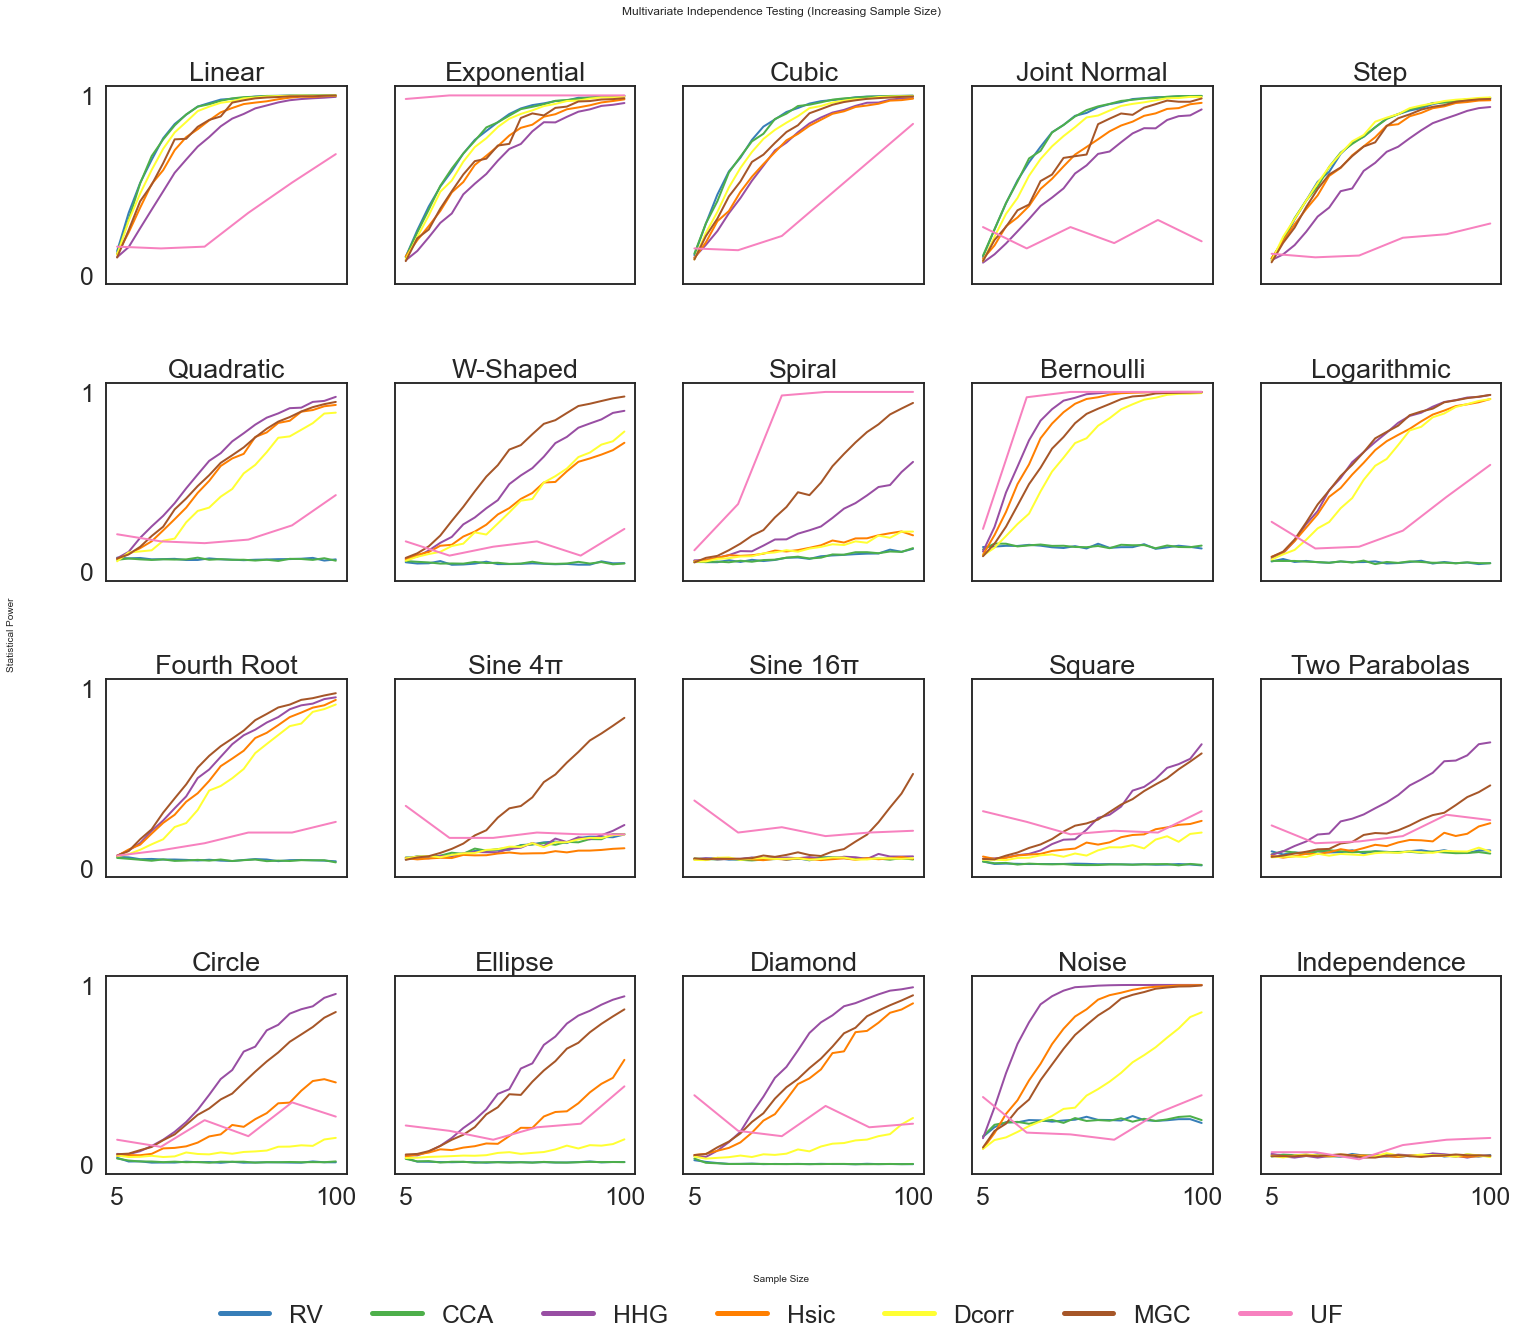

In [7]:
plot_power_all()